In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import signal

In [2]:
data_dir = '..\\data\\input\\NASA\\1st_test\\1st_test'

In [12]:
col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
df = pd.read_csv(data_dir + '/2003.11.10.10.35.58', names=col_names, sep='\t')
df.head()

,b1_ch1,b1_ch2,b2_ch3,b2_ch4,b3_ch5,b3_ch6,b4_ch7,b4_ch8
0,0.073,-0.205,-0.085,-0.222,-0.051,-0.137,-0.029,-0.276
1,-0.042,-0.205,-0.137,-0.208,-0.181,-0.083,-0.107,-0.229
2,-0.156,-0.171,-0.242,-0.159,-0.254,-0.295,-0.188,-0.176
3,-0.063,-0.171,-0.049,-0.149,-0.151,-0.269,-0.188,-0.144
4,0.010,-0.247,-0.005,-0.181,-0.107,-0.264,-0.164,-0.183


In [4]:
df.shape

(20480, 8)

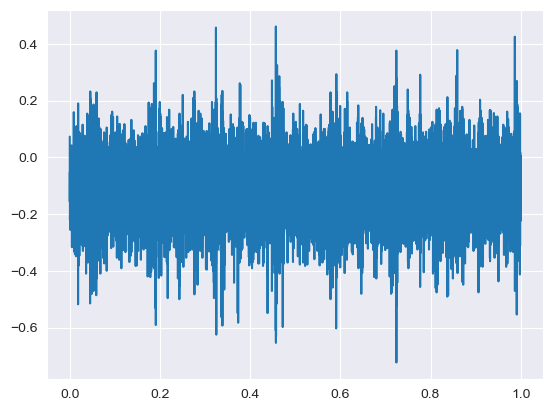

In [13]:
# plot first bearing channel
fig, ax = plt.subplots()

ax.plot(
    np.arange(0,df.shape[0], dtype='float64') / (20.48 * 10**3), # make x-axis in seconds
    df['b1_ch1'] # acceleration data
)

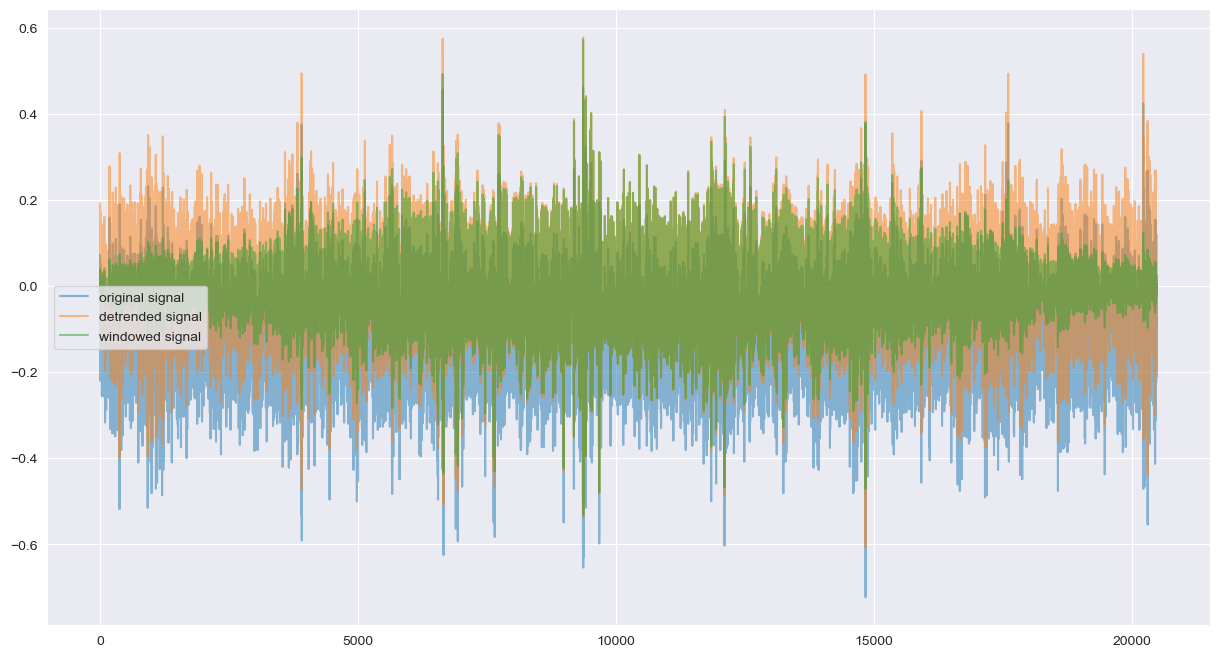

In [14]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['b1_ch1'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['b1_ch1'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 3)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

In [7]:
y_detrend

array([-0.04576315, -0.04578331, -0.00520063, ..., -0.01375874,
       -0.04982831, -0.03382546])

# 自编HHT测试

In [8]:
from src.hht.hht import hht_analysis

In [15]:
imfs, imfs_ht = hht_analysis(y_detrend, 2048, 20480)

In [10]:
imfs

array([[-0.07768012, -0.07542636, -0.02860861, ...,  0.0011539 ,
        -0.0223868 , -0.00049929],
       [ 0.02743904,  0.02443641,  0.01739912, ...,  0.00285548,
        -0.00689987, -0.01176557],
       [ 0.01554918,  0.01663526,  0.01769772, ..., -0.00703826,
        -0.00952449, -0.01032115],
       ...,
       [ 0.0010377 ,  0.00103726,  0.00103682, ...,  0.0041322 ,
         0.00413219,  0.00413217],
       [ 0.00221829,  0.0022184 ,  0.0022185 , ..., -0.00102738,
        -0.00102737, -0.00102736],
       [ 0.00028883,  0.00028881,  0.00028878, ...,  0.00010344,
         0.00010345,  0.00010346]])

In [11]:
imfs_ht[1][:, np.newaxis].shape
imfs_ht[1].shape

(20480,)

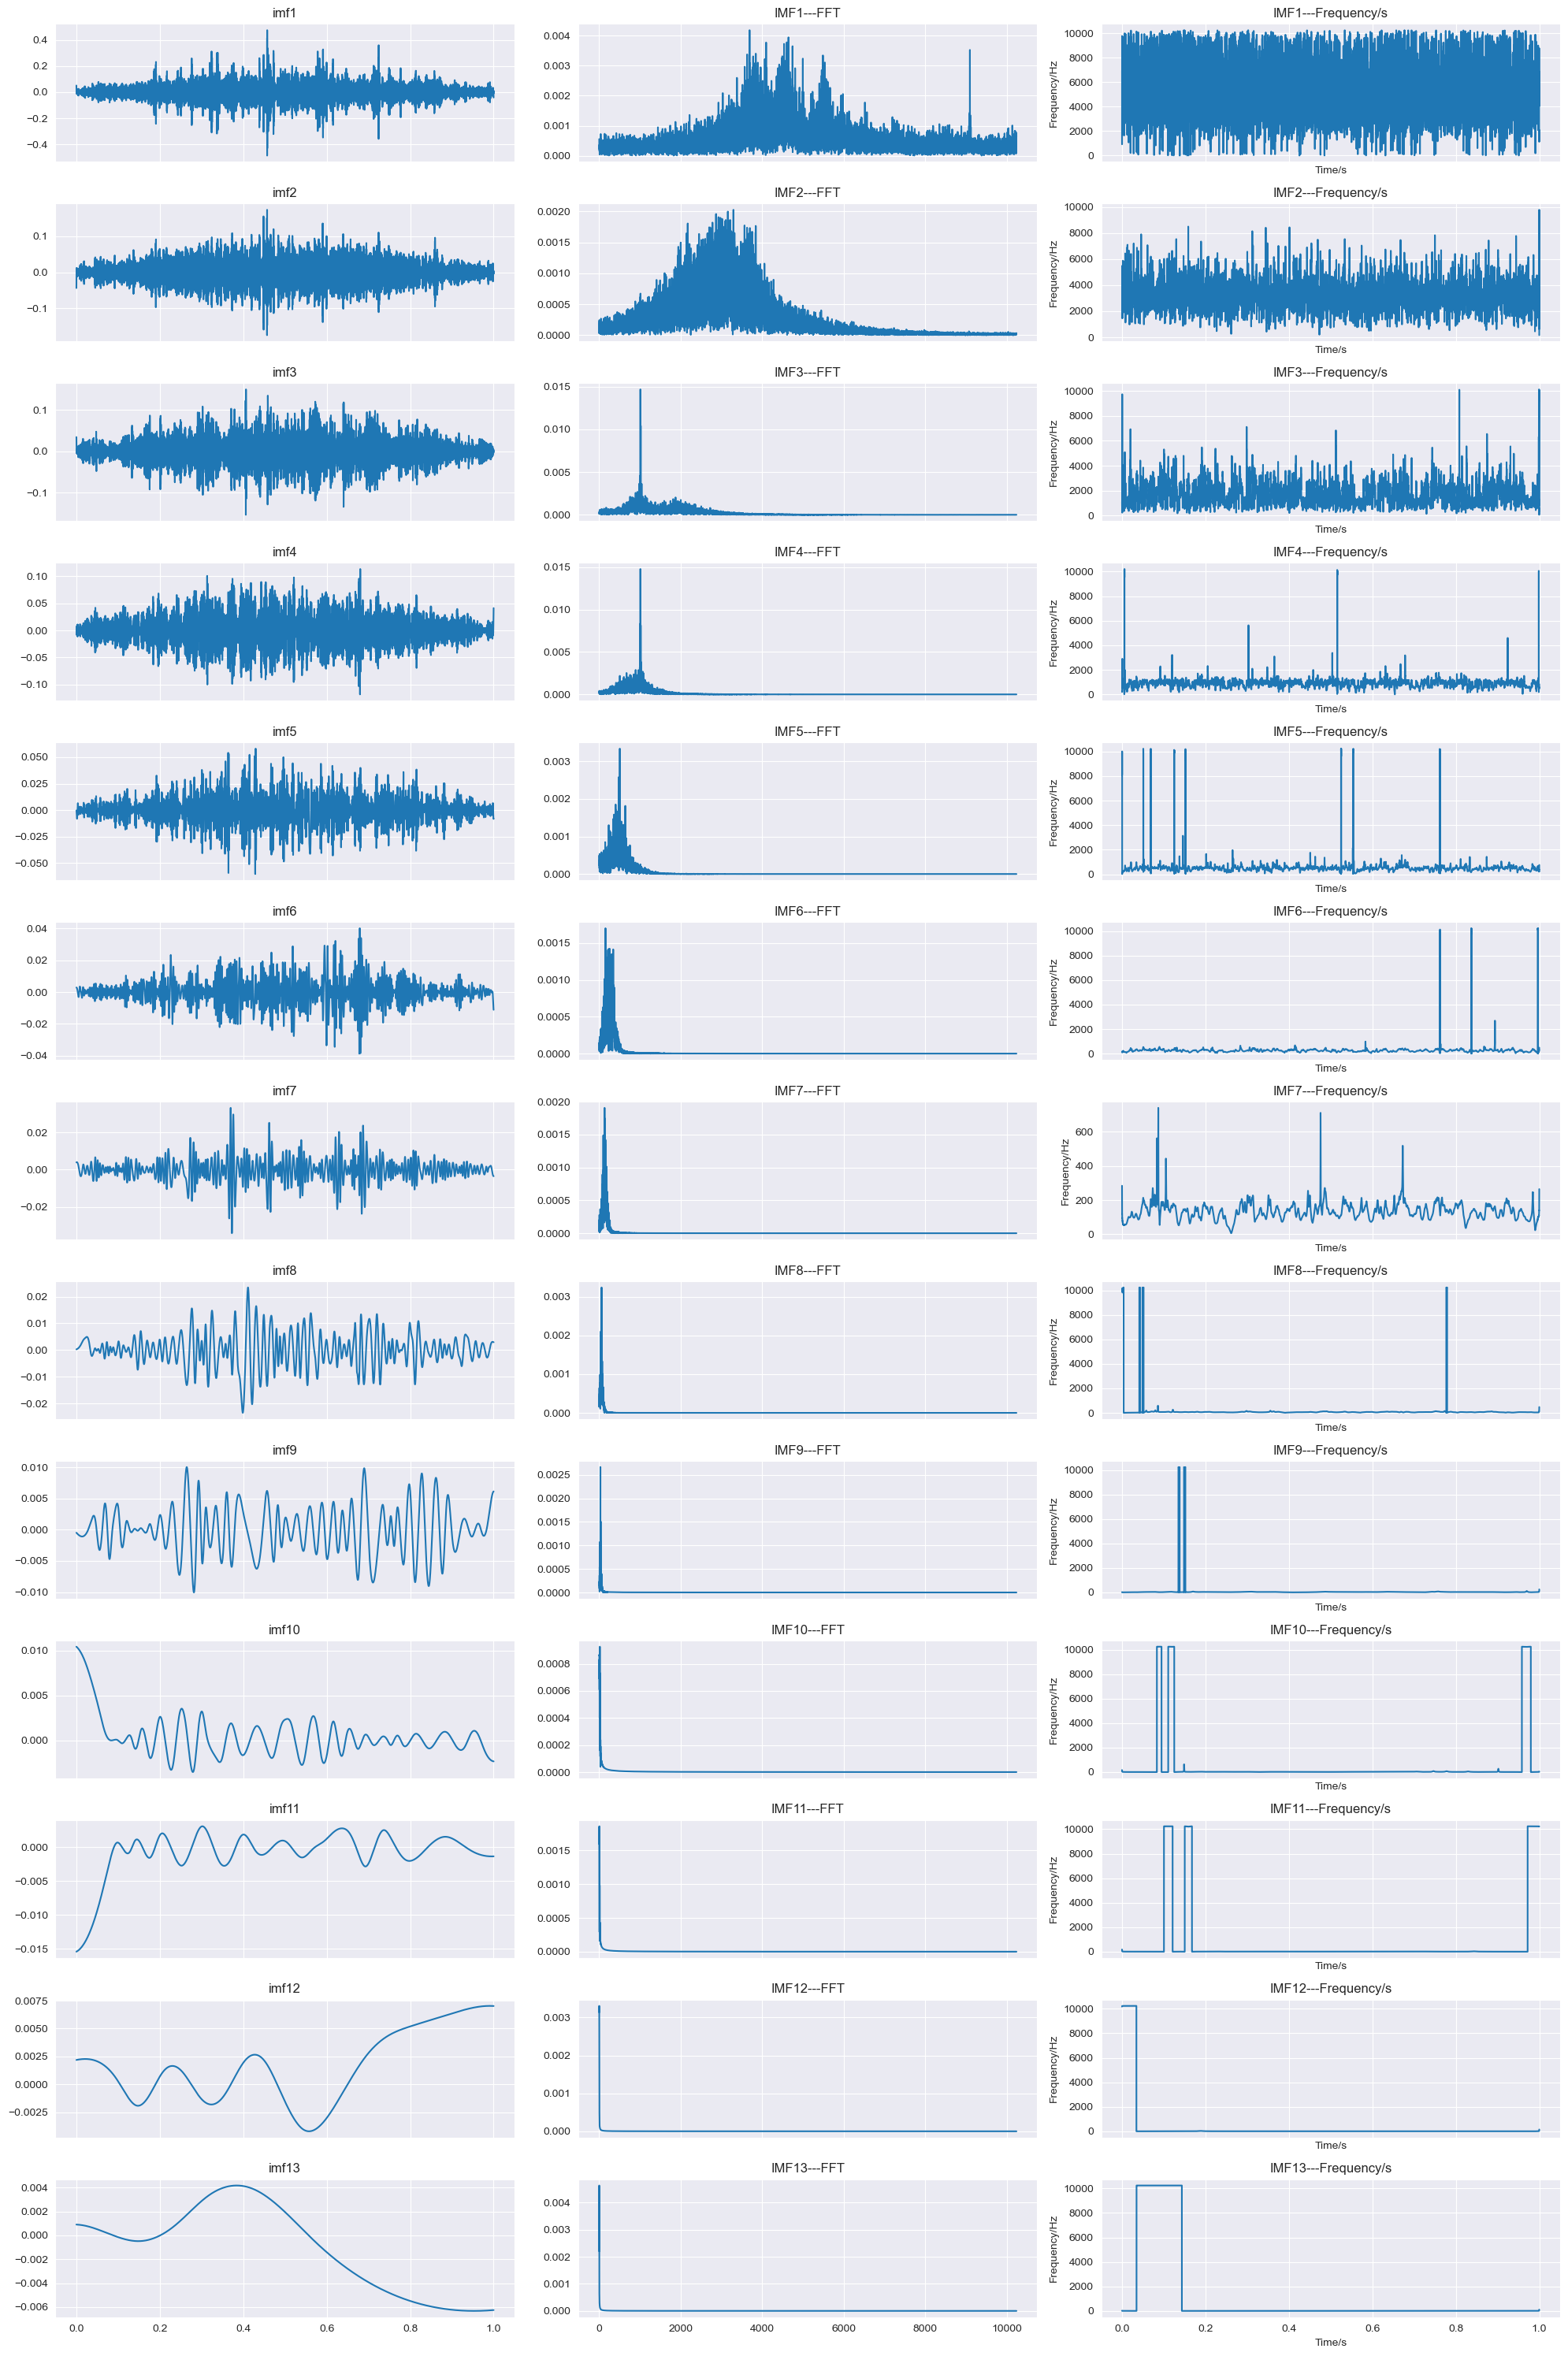

In [16]:
from src.hht.hht import hht_picture

hht_picture(imfs, imfs_ht, np.linspace(0, 1, 20480), 20480)

In [13]:
# import tftb
#
# imfs_ht_temp = imfs_ht[6][:, np.newaxis]
# instf, timestamps = tftb.processing.inst_freq(imfs_ht_temp)
#
# plt.plot(timestamps / 20480, instf * 20480)

In [14]:
# imfs_ht_temp.shape

In [15]:
import tftb

def feature_processing(imfs_ht=np.ndarray):
    n_component= imfs_ht.shape[0]

    frequency_array = []
    feature_array = []
    for i in range(n_component):
        fs = 20480
        imfs_ht_temp = imfs_ht[i][:, np.newaxis]
        instf, timestamps = tftb.processing.inst_freq(imfs_ht_temp)
        frequency_array.append(np.mean(instf * fs))
        pass
    return frequency_array
    pass

arr = feature_processing(imfs_ht)
arr

[5508.793155680326,
 3199.4591548414105,
 1304.8817043680117,
 761.4257871922387,
 484.9257008264205,
 249.9009445235127,
 168.86231604237338,
 153.0162307208409,
 33.913791631375474,
 17.88129890538806,
 443.48604377743635,
 4.937352280521555,
 1.9336332619537397]

# 1st_test数据处理

In [40]:
import pandas as pd
import os
from src.hht.hht import signal_window
from src.hht.hht import feature_processing

merged_data = pd.DataFrame()
col_names = ['b1_ch1', 'b1_ch2', 'b2_ch3', 'b2_ch4', 'b3_ch5', 'b3_ch6', 'b4_ch7', 'b4_ch8']
cnt = 0

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t', names=col_names)
    data_row = []
    for col_name in col_names:
        signal_temp = signal.detrend(dataset[col_name], type='linear')
        signal_temp *= np.kaiser(len(signal_temp), 3)
        imfs_temp, imfs_ht_temp = hht_analysis(signal_temp, 2048, 20480)
        fre_arr = feature_processing(imfs_ht_temp)
        data_row.extend(fre_arr)
        pass
    if len(data_row) <= 1:
        continue
    data_set_temp = pd.DataFrame(np.array(data_row).reshape(1, len(data_row)))
    data_set_temp.index = [filename]
    merged_data = merged_data.append(data_set_temp)
    pass

merged_data

Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 142 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 2, Iteration 600
0 minima > 0; 4227 maxima < 0.
Mode 10, Iteration 800
4 minima > 0; 21 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 115 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 210 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 143 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 6, Iteration 600
0 minima > 0; 270 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1200
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1400
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1600
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1800
1 minima > 0; 10 maxima < 0.


E:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 227 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 42 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 37 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 24 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 10, Iteration 600
2 minima > 0; 37 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 20 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 20 maxima < 0.
Mode 14, Iteration 1200
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 9 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 26 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 5, Iteration 600
1 minima > 0; 772 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
1 minima > 0; 768 maxima < 0.
Mode 9, Iteration 800
0 minima > 0; 28 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 1400
0 minima > 0; 8 maxima < 0.
Mode 14, Iteration 1600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 1200
1 minima > 0; 4 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 480 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1400
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1200
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1400
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1800
1 minima > 0; 6 maxima < 0.


E:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 45 maxima < 0.
Mode 9, Iteration 800
1 minima > 0; 45 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
3 minima > 0; 14 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
1 minima > 0; 1293 maxima < 0.
Mode 6, Iteration 800
0 minima > 0; 409 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 35 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
1 minima > 0; 1 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 22 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 20 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 63 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 9 maxima < 0.
Mode 6, Iteration 600
0 minima > 0; 362 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 26 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 28 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
1 minima > 0; 79 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 15, Iteration 1000
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
4 minima > 0; 10 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 63 maxima < 0.
Mode 9, Iteration 800
0 minima > 0; 41 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
0 minima > 0; 1289 maxima < 0.
Mode 7, Iteration 800
1 minima > 0; 236 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 40 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 213 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 40 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 359 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 37 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
2 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
2 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 33 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 16 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 17 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 17 maxima < 0.
Mode 10, Iteration 1200
0 minima > 0; 17 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 31 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1281 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 73 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 73 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
2 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 5, Iteration 600
0 minima > 0; 504 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 218 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 8, Iteration 600
1 minima > 0; 103 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
1 minima > 0; 92 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 29 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
2 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 248 maxima < 0.
Mode 12, Iteration 800
2 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 770 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 16 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 25 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 178 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 10, Iteration 600
1 minima > 0; 38 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 551 maxima < 0.
Mode 6, Iteration 800
52 minima > 0; 304 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 25 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
1 minima > 0; 82 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 15 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 90 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 5 maxima < 0.
Mode 14, Iteration 1200
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 30 maxima < 0.
Mode 5, Iteration 600
0 minima > 0; 659 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 68 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 44 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 34 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 35 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 33 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
1 minima > 0; 100 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 591 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 9, Iteration 600
1 minima > 0; 51 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 58 maxima < 0.
Mode 15, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 64 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 37 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 2, Iteration 600
0 minima > 0; 3592 maxima < 0.
Mode 2, Iteration 800
1 minima > 0; 3595 maxima < 0.
Mode 2, Iteration 1000
0 minima > 0; 3599 maxima < 0.
Mode 11, Iteration 1200
1 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 32 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 100 maxima < 0.
Mode 5, Iteration 600
0 minima > 0; 578 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
1 minima > 0; 1971 maxima < 0.
Mode 7, Iteration 800
0 minima > 0; 156 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 9, Iteration 600
1 minima > 0; 59 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 2, Iteration 600
0 minima > 0; 3720 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 115 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 115 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 185 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 25 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 21 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 21 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 21 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 48 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 34 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
2 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
4 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1400
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1800
0 minima > 0; 9 maxima < 0.


E:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 35 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1200
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 26 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 67 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 223 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 17 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 81 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 81 maxima < 0.
Mode 8, Iteration 1000
0 minima > 0; 81 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 21 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
1 minima > 0; 2086 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1217 maxima < 0.
Mode 6, Iteration 800
0 minima > 0; 414 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 89 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 14 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 13 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
0 minima > 0; 1269 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 79 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
2 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
0 minima > 0; 2041 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 14 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 14 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 21 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 19 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 19 maxima < 0.
Mode 10, Iteration 1200
0 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 8, Iteration 600
0 minima > 0; 97 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 8, Iteration 600
20 minima > 0; 75 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 33 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 15, Iteration 1400
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
2 minima > 0; 82 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 14, Iteration 1200
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 356 maxima < 0.
Mode 6, Iteration 800
1 minima > 0; 354 maxima < 0.
Mode 6, Iteration 1000
0 minima > 0; 355 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 5, Iteration 600
2 minima > 0; 654 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
2 minima > 0; 75 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 30 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 37 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 43 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 21 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1400
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 9, Iteration 600
6 minima > 0; 40 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 21 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 5, Iteration 600
1 minima > 0; 746 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 7, Iteration 600
2 minima > 0; 191 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 186 maxima < 0.
Mode 7, Iteration 800
1 minima > 0; 187 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 32 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
3 minima > 0; 22 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 34 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 21 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 250 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 28 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
3 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
1 minima > 0; 108 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 283 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 33 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
0 minima > 0; 2247 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 242 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 13 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 411 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
2 minima > 0; 15 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
2 minima > 0; 96 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 10, Iteration 600
1 minima > 0; 38 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 27 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 7, Iteration 600
0 minima > 0; 203 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 252 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 22 maxima < 0.
Mode 10, Iteration 1000
1 minima > 0; 22 maxima < 0.
Mode 10, Iteration 1200
1 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 5, Iteration 600
0 minima > 0; 474 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 14, Iteration 800
1 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 600
2 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 6, Iteration 600
0 minima > 0; 413 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 9 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 15 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 61 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1200 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 117 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 39 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 22 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 5, Iteration 600
1 minima > 0; 842 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 119 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 10, Iteration 600
0 minima > 0; 20 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 255 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 33 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 2, Iteration 600
1 minima > 0; 3680 maxima < 0.
Mode 2, Iteration 800
1 minima > 0; 3687 maxima < 0.
Mode 2, Iteration 1000
1 minima > 0; 3697 maxima < 0.
Mode 3, Iteration 1200
4 minima > 0; 2340 maxima < 0.
Mode 11, Iteration 1400
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1200
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
2 minima > 0; 15 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
2 minima > 0; 27 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 6, Iteration 600
0 minima > 0; 362 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 158 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
2 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 378 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 179 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 49 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
2 minima > 0; 129 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 22 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 195 maxima < 0.
Mode 7, Iteration 800
1 minima > 0; 195 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 17 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 17 maxima < 0.
Mode 13, Iteration 1400
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1200
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1400
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
2 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 21 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 3 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 36 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 1400
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 22 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 54 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 9, Iteration 600
1 minima > 0; 69 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 28 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 22 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 23 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 34 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 172 maxima < 0.
Mode 7, Iteration 800
0 minima > 0; 171 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 186 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 36 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 6, Iteration 600
0 minima > 0; 295 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 98 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 110 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
2 minima > 0; 1214 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
1 minima > 0; 1931 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
0 minima > 0; 872 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1121 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 29 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
2 minima > 0; 242 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 165 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 158 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 21 maxima < 0.
Mode 5, Iteration 600
0 minima > 0; 632 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 390 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 64 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 25 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
1 minima > 0; 1996 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 27 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
2 minima > 0; 124 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 422 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 41 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 58 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 36 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 143 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 112 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 21 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
0 minima > 0; 1163 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 1167 maxima < 0.
Mode 4, Iteration 1000
0 minima > 0; 1172 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 1400
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 1600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 1800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1165 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 1168 maxima < 0.
Mode 4, Iteration 1000
0 minima > 0; 1173 maxima < 0.
Mode 4, Iteration 1200
0 minima > 0; 1173 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 608 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 192 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 24 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 102 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 30 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 9, Iteration 600
1 minima > 0; 51 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 30 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 10, Iteration 600
1 minima > 0; 28 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 2, Iteration 600
0 minima > 0; 3847 maxima < 0.
Mode 2, Iteration 800
0 minima > 0; 3860 maxima < 0.
Mode 2, Iteration 1000
0 minima > 0; 3867 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 2411 maxima < 0.
Mode 12, Iteration 1400
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 1600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 23 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1271 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 35 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 15, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 35 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 27 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 225 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
1 minima > 0; 2 maxima < 0.
Mode 6, Iteration 600
0 minima > 0; 437 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 62 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 31 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 31 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 31 maxima < 0.
Mode 10, Iteration 1200
0 minima > 0; 31 maxima < 0.
Mode 10, Iteration 1400
0 minima > 0; 31 maxima < 0.
Mode 12, Iteration 1600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 3 maxima < 0.
Mode 14, Iteration 600
1 minima > 0; 1 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 32 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 26 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 80 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 51 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 26 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 70 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 71 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
1 minima > 0; 642 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 21 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 214 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 27 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 20 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 2, Iteration 600
1 minima > 0; 3725 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 767 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 5, Iteration 600
2 minima > 0; 650 maxima < 0.
Mode 5, Iteration 800
1 minima > 0; 651 maxima < 0.
Mode 7, Iteration 1000
0 minima > 0; 252 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 15 maxima < 0.
Mode 14, Iteration 1400
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 2163 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
1 minima > 0; 734 maxima < 0.
Mode 6, Iteration 600
0 minima > 0; 457 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 64 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
3 minima > 0; 8 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 81 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 53 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 21 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1200
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 1400
1 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 360 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 25 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 2098 maxima < 0.
Mode 6, Iteration 800
1 minima > 0; 436 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1373 maxima < 0.
Mode 6, Iteration 800
1 minima > 0; 532 maxima < 0.
Mode 7, Iteration 1000
0 minima > 0; 351 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 15 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 15 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 2079 maxima < 0.
Mode 9, Iteration 800
0 minima > 0; 66 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 9 maxima < 0.
Mode 14, Iteration 1200
0 minima > 0; 4 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 2046 maxima < 0.
Mode 4, Iteration 800
2 minima > 0; 1354 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 144 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 250 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 25 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 7 maxima < 0.
Mode 3, Iteration 600
2 minima > 0; 2319 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 138 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 2, Iteration 600
0 minima > 0; 3364 maxima < 0.
Mode 2, Iteration 800
1 minima > 0; 3372 maxima < 0.
Mode 3, Iteration 1000
1 minima > 0; 2274 maxima < 0.
Mode 10, Iteration 1200
1 minima > 0; 37 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 2, Iteration 600
0 minima > 0; 3256 maxima < 0.
Mode 5, Iteration 800
1 minima > 0; 743 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 141 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 3, Iteration 600
2 minima > 0; 2187 maxima < 0.
Mode 3, Iteration 800
3 minima > 0; 2203 maxima < 0.
Mode 4, Iteration 1000
0 minima > 0; 1430 maxima < 0.
Mode 7, Iteration 1200
1 minima > 0; 296 maxima < 0.
Mode 10, Iteration 1400
1 minima > 0; 64 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1161 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 1161 maxima < 0.
Mode 4, Iteration 1000
1 minima > 0; 1163 maxima < 0.
Mode 4, Iteration 1200
0 minima > 0; 1166 maxima < 0.
Mode 9, Iteration 600
14 minima > 0; 57 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
2 minima > 0; 643 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 15, Iteration 1000
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 73 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 230 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 269 maxima < 0.
Mode 9, Iteration 800
1 minima > 0; 84 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 2, Iteration 600
1 minima > 0; 3773 maxima < 0.
Mode 3, Iteration 800
0 minima > 0; 2398 maxima < 0.
Mode 10, Iteration 1000
1 minima > 0; 33 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 75 maxima < 0.
Mode 14, Iteration 800
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 83 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 30 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 396 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 24 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 93 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 63 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 7, Iteration 600
4 minima > 0; 226 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1210 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 33 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 432 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 250 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 3 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
1 minima > 0; 389 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
1 minima > 0; 373 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 20 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 320 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 444 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 7, Iteration 600
2 minima > 0; 230 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
0 minima > 0; 1392 maxima < 0.
Mode 10, Iteration 800
6 minima > 0; 37 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 729 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 357 maxima < 0.
Mode 8, Iteration 800
1 minima > 0; 137 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 226 maxima < 0.
Mode 7, Iteration 800
0 minima > 0; 224 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 22 maxima < 0.
Mode 11, Iteration 1200
1 minima > 0; 22 maxima < 0.
Mode 11, Iteration 1400
1 minima > 0; 22 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 40 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 73 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 267 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 27 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 38 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 8, Iteration 600
2 minima > 0; 130 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 16 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 2, Iteration 600
38 minima > 0; 3509 maxima < 0.
Mode 2, Iteration 800
2 minima > 0; 3647 maxima < 0.
Mode 2, Iteration 1000
0 minima > 0; 3666 maxima < 0.
Mode 6, Iteration 1200
0 minima > 0; 448 maxima < 0.
Mode 11, Iteration 1400
1 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 44 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
2 minima > 0; 33 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 7, Iteration 600
2 minima > 0; 252 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 139 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 125 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 125 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 442 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 61 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 20 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1388 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 152 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 1852 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 447 maxima < 0.
Mode 6, Iteration 800
0 minima > 0; 462 maxima < 0.
Mode 8, Iteration 1000
1 minima > 0; 164 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 11 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 11 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1283 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 1288 maxima < 0.
Mode 6, Iteration 1000
2 minima > 0; 503 maxima < 0.
Mode 9, Iteration 1200
0 minima > 0; 102 maxima < 0.
Mode 11, Iteration 1400
0 minima > 0; 45 maxima < 0.
Mode 12, Iteration 1600
1 minima > 0; 25 maxima < 0.
Mode 14, Iteration 1800
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
1 minima > 0; 1365 maxima < 0.
Mode 6, Iteration 800
1 minima > 0; 528 maxima < 0.
Mode 8, Iteration 1000
0 minima > 0; 206 maxima < 0.
Mode 8, Iteration 1200
1 minima > 0; 209 maxima < 0.
Mode 10, Iteration 1400
9 minima > 0; 73 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
3 minima > 0; 95 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 41 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
3 minima > 0; 1272 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 806 maxima < 0.
Mode 6, Iteration 1000
2 minima > 0; 508 maxima < 0.
Mode 6, Iteration 1200
0 minima > 0; 509 maxima < 0.
Mode 9, Iteration 1400
0 minima > 0; 107 maxima < 0.
Mode 14, Iteration 1600
0 minima > 0; 3 maxima < 0.
Mode 5, Iteration 600
2 minima > 0; 779 maxima < 0.
Mode 7, Iteration 800
2 minima > 0; 304 maxima < 0.
Mode 7, Iteration 1000
0 minima > 0; 319 maxima < 0.
Mode 7, Iteration 1200
2 minima > 0; 314 maxima < 0.
Mode 7, Iteration 1400
1 minima > 0; 313 maxima < 0.
Mode 7, Iteration 1600
0 minima > 0; 314 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
0 minima > 0; 1225 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 1235 maxima < 0.
Mode 8, Iteration 1000
0 minima > 0; 159 maxima < 0.
Mode 11, Iteration 1200
0 minima > 0; 29 maxima < 0.
Mode 14, Iteration 1400
0 minima > 0; 7 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 2288 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 874 maxima < 0.
Mode 6, Iteration 1000
1 minima > 0; 504 maxima < 0.
Mode 6, Iteration 1200
1 minima > 0; 503 maxima < 0.
Mode 12, Iteration 1400
1 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
2 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
2 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 5, Iteration 600
0 minima > 0; 770 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 50 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 7, Iteration 600
1 minima > 0; 211 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 29 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 5, Iteration 600
3 minima > 0; 806 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
1 minima > 0; 411 maxima < 0.
Mode 7, Iteration 600
2 minima > 0; 230 maxima < 0.
Mode 7, Iteration 800
0 minima > 0; 234 maxima < 0.
Mode 10, Iteration 1000
0 minima > 0; 43 maxima < 0.
Mode 10, Iteration 1200
0 minima > 0; 45 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 65 maxima < 0.
Mode 10, Iteration 600
1 minima > 0; 26 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 79 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 68 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 71 maxima < 0.
Mode 10, Iteration 600
1 minima > 0; 39 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 5, Iteration 600
1 minima > 0; 781 maxima < 0.
Mode 5, Iteration 800
1 minima > 0; 790 maxima < 0.
Mode 5, Iteration 1000
1 minima > 0; 791 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 87 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 8, Iteration 600
1 minima > 0; 147 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 59 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 17 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 11 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 2273 maxima < 0.
Mode 9, Iteration 800
0 minima > 0; 81 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 234 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 339 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1175 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 119 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 12 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 13 maxima < 0.
Mode 11, Iteration 1200
1 minima > 0; 12 maxima < 0.
Mode 11, Iteration 1400
1 minima > 0; 12 maxima < 0.
Mode 11, Iteration 1600
1 minima > 0; 12 maxima < 0.
Mode 11, Iteration 1800
1 minima > 0; 12 maxima < 0.


E:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 35 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 5 maxima < 0.
Mode 15, Iteration 1200
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 60 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
1 minima > 0; 1371 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 42 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1006 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
1 minima > 0; 368 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 221 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 123 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 24 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 27 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 25 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 32 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 253 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 23 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 23 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 230 maxima < 0.
Mode 9, Iteration 800
0 minima > 0; 90 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
1 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 5, Iteration 600
2 minima > 0; 668 maxima < 0.
Mode 8, Iteration 800
0 minima > 0; 119 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 63 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 750 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 27 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 6, Iteration 600
1 minima > 0; 434 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 87 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 59 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1274 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
2 minima > 0; 124 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 679 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 26 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 441 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 278 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 15 maxima < 0.
Mode 2, Iteration 600
0 minima > 0; 3167 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 19 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 232 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 10, Iteration 800
0 minima > 0; 14 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 6, Iteration 600
2 minima > 0; 457 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
2 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 86 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
2 minima > 0; 2091 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 6 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
2 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 548 maxima < 0.
Mode 3, Iteration 600
20 minima > 0; 2283 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
1 minima > 0; 380 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 1974 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 1276 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 15 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
66 minima > 0; 595 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 3, Iteration 600
1 minima > 0; 2443 maxima < 0.
Mode 9, Iteration 800
0 minima > 0; 51 maxima < 0.
Mode 9, Iteration 1000
1 minima > 0; 50 maxima < 0.
Mode 9, Iteration 1200
1 minima > 0; 51 maxima < 0.
Mode 9, Iteration 1400
1 minima > 0; 51 maxima < 0.
Mode 9, Iteration 1600
1 minima > 0; 51 maxima < 0.
Mode 9, Iteration 1800
1 minima > 0; 51 maxima < 0.


E:\ProgramData\Anaconda3\lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 32 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 20 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 385 maxima < 0.
Mode 14, Iteration 800
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
2 minima > 0; 250 maxima < 0.
Mode 11, Iteration 800
5 minima > 0; 22 maxima < 0.
Mode 15, Iteration 1000
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 33 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 19 maxima < 0.
Mode 11, Iteration 1000
1 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 59 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 52 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 17 maxima < 0.
Mode 11, Iteration 1000
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 25 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 21 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 37 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
0 minima > 0; 752 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 42 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 7, Iteration 600
1 minima > 0; 230 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 1450 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
3 minima > 0; 474 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 46 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1200
2 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1400
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
14 minima > 0; 83 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
0 minima > 0; 150 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 17 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 19 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
1 minima > 0; 252 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 250 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 6 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 7 maxima < 0.
Mode 15, Iteration 1400
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 54 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 44 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 9, Iteration 600
0 minima > 0; 65 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 41 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 15 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 36 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 250 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 9 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 13 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 12, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 12, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 12, Iteration 1000
1 minima > 0; 11 maxima < 0.
Mode 13, Iteration 1200
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 8, Iteration 600
0 minima > 0; 146 maxima < 0.
Mode 11, Iteration 600
4 minima > 0; 14 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 8, Iteration 600
1 minima > 0; 145 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 14, Iteration 1000
0 minima > 0; 4 maxima < 0.
Mode 14, Iteration 1200
0 minima > 0; 5 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 11, Iteration 800
1 minima > 0; 23 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 18 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 7, Iteration 600
0 minima > 0; 208 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 16 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 2 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 43 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
0 minima > 0; 76 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 10, Iteration 600
0 minima > 0; 36 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 6, Iteration 600
0 minima > 0; 420 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 27 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 18 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 1935 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 1260 maxima < 0.
Mode 12, Iteration 1000
4 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
1 minima > 0; 1 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 18 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 4, Iteration 600
1 minima > 0; 1211 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
1 minima > 0; 16 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
1 minima > 0; 14 maxima < 0.
Mode 10, Iteration 800
1 minima > 0; 14 maxima < 0.
Mode 10, Iteration 1000
1 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 11, Iteration 600
2 minima > 0; 10 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 10, Iteration 600
1 minima > 0; 38 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 7, Iteration 600
0 minima > 0; 180 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 12 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 23 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 10, Iteration 600
0 minima > 0; 26 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 5, Iteration 600
1 minima > 0; 599 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 10 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
1 minima > 0; 14 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 15, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 9 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1000
0 minima > 0; 8 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 24 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
3 minima > 0; 19 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1000
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1200
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1400
1 minima > 0; 4 maxima < 0.
Mode 13, Iteration 1600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 1800
0 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
1 minima > 0; 3 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_se

Mode 7, Iteration 600
0 minima > 0; 232 maxima < 0.
Mode 13, Iteration 800
0 minima > 0; 6 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 6 maxima < 0.
Mode 11, Iteration 600
0 minima > 0; 17 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 13, Iteration 600
1 minima > 0; 4 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 800
1 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
1 minima > 0; 5 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 1228 maxima < 0.
Mode 11, Iteration 800
0 minima > 0; 16 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 13 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 11 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 14, Iteration 600
0 minima > 0; 3 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 13, Iteration 600
0 minima > 0; 5 maxima < 0.
Mode 13, Iteration 600
0 minima > 0; 2 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 9, Iteration 600
1 minima > 0; 63 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 9 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 12, Iteration 600
0 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
0 minima > 0; 7 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


Mode 11, Iteration 600
0 minima > 0; 10 maxima < 0.
Mode 12, Iteration 800
0 minima > 0; 7 maxima < 0.
Mode 12, Iteration 1000
0 minima > 0; 7 maxima < 0.
Mode 13, Iteration 1200
1 minima > 0; 4 maxima < 0.
Mode 12, Iteration 600
1 minima > 0; 8 maxima < 0.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14512\1070209128.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data_set_temp)


,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
2003.10.22.12.06.24,5508.793156,3199.459155,1304.881704,761.425787,484.925701,249.900945,168.862316,153.016231,33.913792,17.881299,...,132.455172,233.953974,138.944598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003.10.22.12.09.13,5588.578002,3410.630291,1636.123918,878.440618,478.488901,246.878724,340.952527,110.396082,110.432185,138.941031,...,12.919012,126.438116,193.460022,250.475036,NaN,NaN,NaN,NaN,NaN,NaN
2003.10.22.12.14.13,5550.870882,3200.821742,1404.078117,801.288153,469.451778,281.944109,140.094364,59.858343,228.455418,16.908338,...,71.454660,1.945090,2685.724801,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003.10.22.12.19.13,5530.509480,3181.605029,1302.461128,740.596579,454.492945,261.993908,154.915690,76.433516,109.920314,33.437423,...,142.448431,900.513114,557.508792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003.10.22.12.24.13,5511.856659,3246.142635,1404.487848,763.995261,413.915901,207.357023,99.857710,80.406163,27.910194,12.908154,...,169.459501,229.950760,9.911620,64.475468,819.016235,0.940375,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003.11.25.16.07.32,5182.495063,2979.089255,1443.964972,837.464556,454.917084,282.368524,172.397088,86.404842,30.918337,43.426014,...,37.426126,59.961800,162.418921,676.513849,NaN,NaN,NaN,NaN,NaN,NaN
2003.11.25.23.13.21,5199.115357,3105.162534,1518.905840,844.839013,489.354365,285.409247,155.459118,69.903371,53.933372,309.965545,...,19.444169,9.927621,4.928351,852.520389,251.482423,NaN,NaN,NaN,NaN,NaN
2003.11.25.23.19.56,5221.456665,3164.048308,1436.984172,784.402381,438.926559,258.985793,137.460622,60.902203,148.425680,17.841654,...,53.442965,35.983978,7.908681,207.436611,1.942963,0.943062,NaN,NaN,NaN,NaN
2003.11.25.23.29.56,5156.333447,3086.853683,1360.894626,782.497386,472.501388,250.285550,126.908336,166.925468,310.932741,25.456581,...,84.438838,21.925902,3.929850,0.940142,NaN,NaN,NaN,NaN,NaN,NaN
